## Hong Benchmark F1plusF2 (no training) just PDF shaping

* Benchmark Hong 
* I had to inititalize the weights to 1 to intentionally create a crazy neural net in the beginning that was a big challenge for PDF shaping

## Inputs

(0, 'i_u1')

(1, 'i_u2')



## Outputs


(0, 'o_y')




In [1]:


import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch

from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)


In [2]:

import PDFshapingUtils as PDF_tk


In [3]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()


## Impulse Function Target

In [4]:

PDFshapingOBJ.N_error_range =  50                                ## check error range and then select

PDFshapingOBJ.initializeImpulseGaussian()
## PDFshapingOBJ.initializeImpulseToOtherShapes()                ## debug only, remove rc

print(PDFshapingOBJ.x_range_impulse_func )
print(PDFshapingOBJ.impulse_func_vector_vals )
print(PDFshapingOBJ.x_range_impulse_func.shape )
print(PDFshapingOBJ.impulse_func_vector_vals.shape )
 
print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


tensor([-50.0000, -49.9900, -49.9800,  ...,  49.9700,  49.9800,  49.9900])
tensor([0., 0., 0.,  ..., 0., 0., 0.])
torch.Size([10000])
torch.Size([10000])
tensor(100.0000)


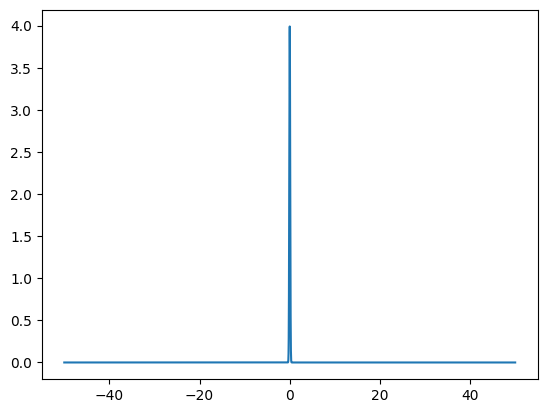

In [5]:

plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
plt.show()


## This is just to test with fake data the KDE

torch.Size([400, 5])


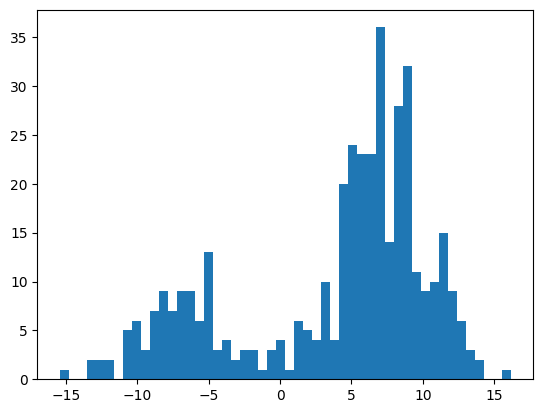

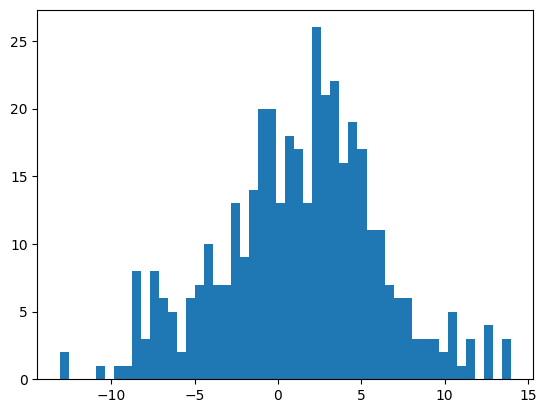

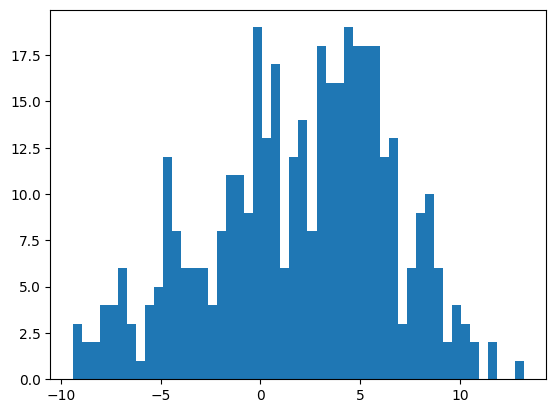

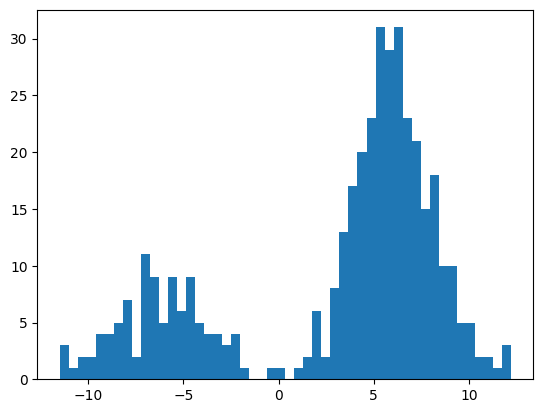

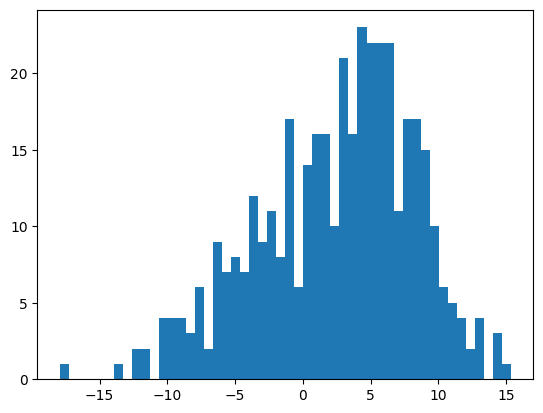

torch.Size([400, 5])
tensor([[  3.1770,   5.1432,   2.0756,   6.0642,   0.4088],
        [  5.9019,   6.6331,   7.8840,   1.0468,   4.7568],
        [  4.7070,   1.8682,   3.7463,   5.9085,   4.0465],
        ...,
        [-10.9057,   2.6946,  -0.2069,  -4.7866,  -3.6819],
        [-13.2696,  -0.7833,  -7.5853,  -9.8053,  -7.9169],
        [ -7.9433,  -3.5088,  -1.0096,  -5.0449,  -2.0944]],
       dtype=torch.float64)
5
0
torch.Size([400])
1
torch.Size([400])
2
torch.Size([400])
3
torch.Size([400])
4
torch.Size([400])
torch.Size([10000, 5])


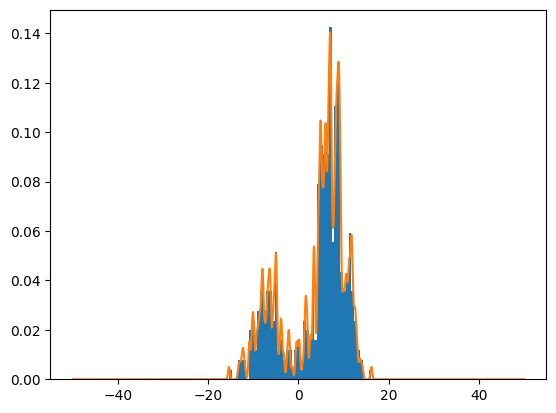

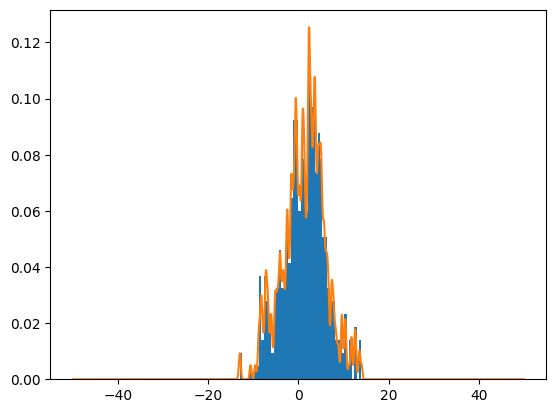

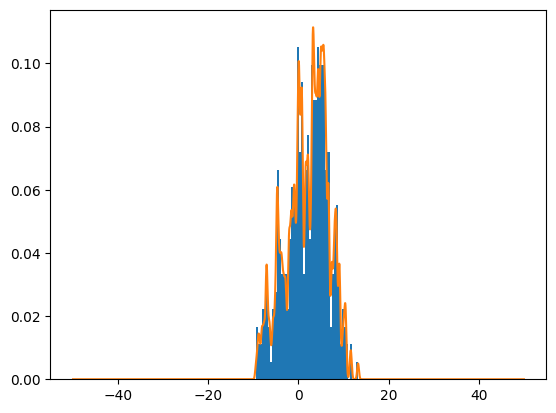

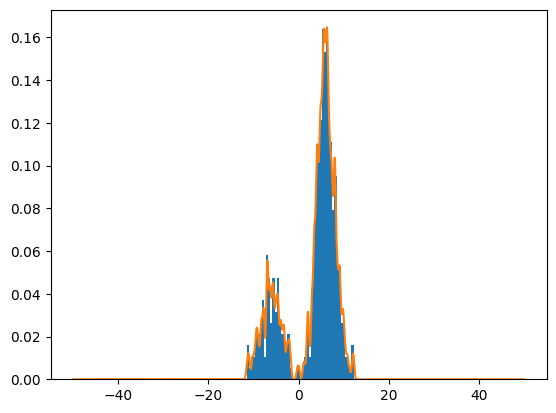

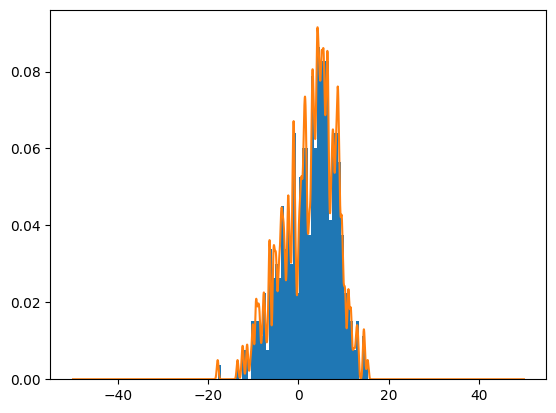

tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)
tensor(100.0000, dtype=torch.float64)


In [6]:

PDFshapingOBJ.test_torchKDE_with_fake_data()


In [7]:

PDFshapingOBJ.read_csv_file_with_pandas('benchmarks/BenchmarkDataHong.csv')


In [8]:
PDFshapingOBJ.CFD_raw_data

,i_u1,i_u2,o_y
0,0.000077,1.2406,10.0000
1,0.000238,1.0155,10.0000
2,0.000740,1.3879,10.0010
3,0.001617,1.0262,10.0020
4,0.003202,1.9126,10.0020
...,...,...,...
995,51.626000,34.4560,11.4980
996,20.462000,28.9600,10.7070
997,37.754000,26.4760,11.4260
998,-10.288000,35.7610,9.7123


In [9]:

PDFshapingOBJ.print_headers_list()


['i_u1', 'i_u2', 'o_y']
3
(0, 'i_u1')
(1, 'i_u2')
(2, 'o_y')


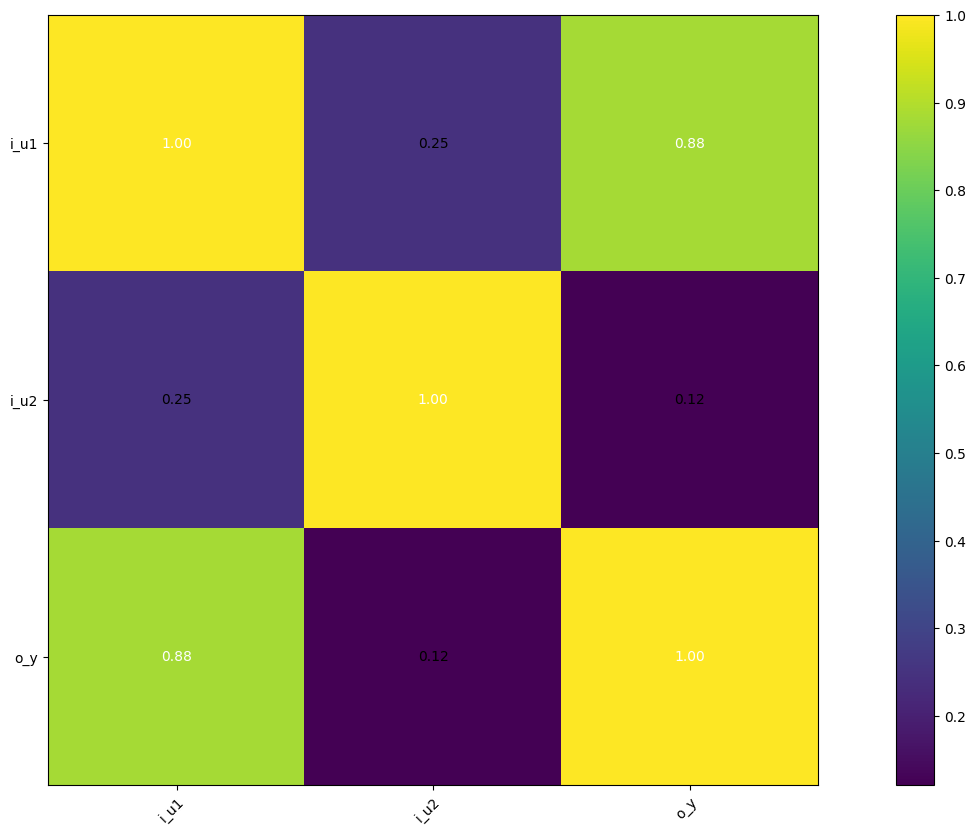

In [10]:

PDFshapingOBJ.list_of_selected_column_names = ['i_u1', 'i_u2', 'o_y']

PDFshapingOBJ.print_correlation_coefficients()


In [11]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[  0.0000774    1.2406      10.        ]
 [  0.00023827   1.0155      10.        ]
 [  0.00073993   1.3879      10.001     ]
 ...
 [ 37.754       26.476       11.426     ]
 [-10.288       35.761        9.7123    ]
 [-63.098       30.914        7.9589    ]]
(1000, 3)


In [12]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs=[0, 1] , 
                   outputs=[2]   
)


2
1


In [13]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)



(1000, 2)
(1000, 1)


In [14]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [15]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(800, 2)
(200, 2)
(800, 1)
(200, 1)


In [16]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [17]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [18]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


## NN architectures

In [19]:

#######################################################
## Linear Regression

class LinRegNet_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 1) 
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)

    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        y_scaled = self.linear1(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

    
#############################################################
## Multi-Layer Perceptron

class MLP_Net_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.zeros_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.zeros_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
    
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        
        y_scaled = self.linear2(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    

#############################################################
## Deep Learning model with 2 hidden layers


class DL_Net_SIO(nn.Module):
    
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.linear1 = nn.Linear(2, 10)
        self.act1    = nn.Sigmoid()                       ## Tanh() 
        self.linear2 = nn.Linear(10, 6)
        self.act2    = nn.Sigmoid() 
        self.linear3 = nn.Linear(6, 1)
        self.dropout = nn.Dropout(0.25)
        
        ## nn.init.xavier_uniform_(self.linear1.weight)
        ## nn.init.zeros_(self.linear1.bias)
        
        ## nn.init.xavier_uniform_(self.linear2.weight)
        ## nn.init.zeros_(self.linear2.bias)
        
        ## nn.init.xavier_uniform_(self.linear3.weight)
        ## nn.init.zeros_(self.linear3.bias)
    
    ## perform inference
    def forward(self, x):
        
        x = (x - self.x_means) / self.x_deviations
        x = self.linear1(x)
        x = self.act1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.act2(x)
        ## x = self.dropout(x)
        
        y_scaled = self.linear3(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled

      
#############################################################


In [20]:


#############################################################
##   F1      plus       F2
## Linear     +      Nonlinear

class F1plusF2_SIO(nn.Module):
    ## initialize the layers
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        ## F1
        self.f1_linear1 = nn.Linear(2, 1)       
        
        ## F2
        self.f2_linear1 = nn.Linear(2, 10)
        self.f2_act1    = nn.Sigmoid()                    ## Tanh()                       
        self.f2_linear2 = nn.Linear(10, 1)       
        self.f2_dropout = nn.Dropout(0.25)
        
        nn.init.ones_(self.f1_linear1.weight)   ## intitializing to all ones to see PDF shaping effect, remove
        nn.init.ones_(self.f1_linear1.bias) 
        
        nn.init.ones_(self.f2_linear1.weight) 
        nn.init.ones_(self.f2_linear1.bias) 
        
        nn.init.ones_(self.f2_linear2.weight) 
        nn.init.ones_(self.f2_linear2.bias) 
        
        
    ## perform inference
    def forward(self, x):
        x = (x - self.x_means) / self.x_deviations
        
        ## F1
        f1 = self.f1_linear1(x)
        
        ## F2
        f2 = self.f2_linear1(x)
        f2 = self.f2_act1(f2)
        f2 = self.f2_dropout(f2)
        f2 = self.f2_linear2(f2)
        
        
        y_scaled   = f1 + f2
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    



In [21]:

class SigmaNN(nn.Module):
    ## initialize the layers
    def __init__(self):
        super().__init__()
        
     
        self.linear1 = nn.Linear(4000, 1000)
        self.act1    = nn.Sigmoid()          ## nn.Tanh()          ## Sigmoid()       nn.GELU()  
        self.linear2 = nn.Linear(1000, 500)
        self.act2    = nn.Sigmoid()         ## nn.Tanh()          ## Sigmoid()       nn.GELU()   
        self.linear3 = nn.Linear(500, 24000)   
        self.act3    = nn.Sigmoid() 
        self.dropout = nn.Dropout(0.25)
        
        
    ## perform inference
    def forward(self, x):
     
        f = self.linear1(x)
        f = self.act1(f)
        f = self.dropout(f)
        f = self.linear2(f)
        f = self.act2(f)
        f = self.dropout(f)
        f = self.linear3(f)
        f = self.act3(f)
 
        return f
    

In [22]:

def my_loss_UNKNOWN_error_PDF(epoch, output, target):
    error = output.float() - target.float()                            ## 400 X 5
    impulseFunc = ImpulseGaussian(x, mean_impulse, std_impulse**2)        ## 4000 X 1
    basisFunc = train_multiple_kernels_per_output(x, error, bandwidth)    ## 4000 x 5
    
    if epoch % 50 == 0:
        print_errors_kdes(error, x, basisFunc)
        print(impulseFunc.shape)
        print(basisFunc.shape)
    
    basisFunc = basisFunc.T
    diff = ( basisFunc.float() -  impulseFunc.float()  )                 ## 4000 x 5
    loss = torch.mean(   (   diff  )**2    )   
    ## reg_sigma_func = (loss ** 2) * use_regularization
    ## loss = loss * ( 1.0 + reg_sigma_func )
    return loss


In [23]:

def my_loss_known_is_gauss(output, target):
       
    error = output.float() - target.float() 
    basisFunc   =  kernel_density(x, error, h)
    diff = ( basisFunc.float() -  impulseFunc.float()  )        
    loss = torch.mean(   (   diff  )**2    )    ## / h
    return loss


## Results for g(x) = F1(x) + F2(x) with No PDF shaping

F1 = Linear

F2 = Nonlinear

In [24]:

def fit_y_scaled(num_epochs, model, loss_fn, opt):
    
    PDFshapingOBJ.list_metric = []
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
            
            
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(
            torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()   )
            )
        )
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,           PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy()  ))
    



In [25]:
PDFshapingOBJ.the_string           = "No_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"

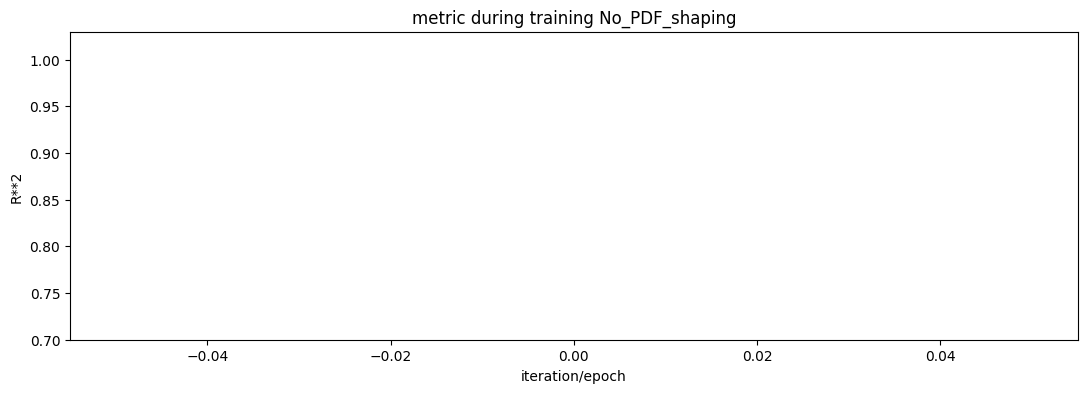

Training loss: tensor(82.6403, grad_fn=<MseLossBackward0>)
Training R**2: -4.777345913053972
Test loss - scaled: tensor(84.7729, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(318.4641, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: -4.44636527093358
Testing R**2 - descaled: -4.446365400380937
*****
*****
Testing R**2 - Output: 0 o_y -4.446365400380937


In [26]:

PDFshapingOBJ.N_EPOCHS = 0

model = F1plusF2_SIO(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

opt = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
loss_fn = F.mse_loss


fit_y_scaled(PDFshapingOBJ.N_EPOCHS, model, loss_fn, opt)


pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,         PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,       PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()    ))

PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


In [27]:
list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(18.66159, 10.052)
**************************************************
preds, real
(25.466866, 10.844)
**************************************************
preds, real
(17.92973, 8.5311)
**************************************************
preds, real
(36.3369, 11.16)
**************************************************
preds, real
(39.969162, 12.573)
**************************************************
preds, real
(28.5095, 11.647)
**************************************************
preds, real
(26.784407, 10.231)
**************************************************
preds, real
(29.291887, 9.0179)
**************************************************
preds, real
(25.611862, 8.6863)
**************************************************
preds, real
(23.968054, 7.9747)
**************************************************
preds, real
(23.49184, 9.977)
**************************************************
preds, real
(20.759342, 9.6171)
*************

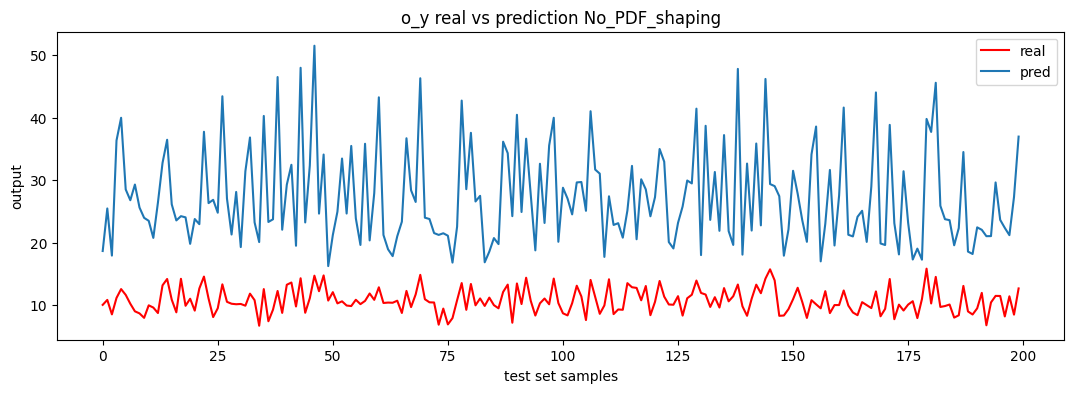

/Users/user/Desktop/DOE_CIVS/experiments/2023april/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


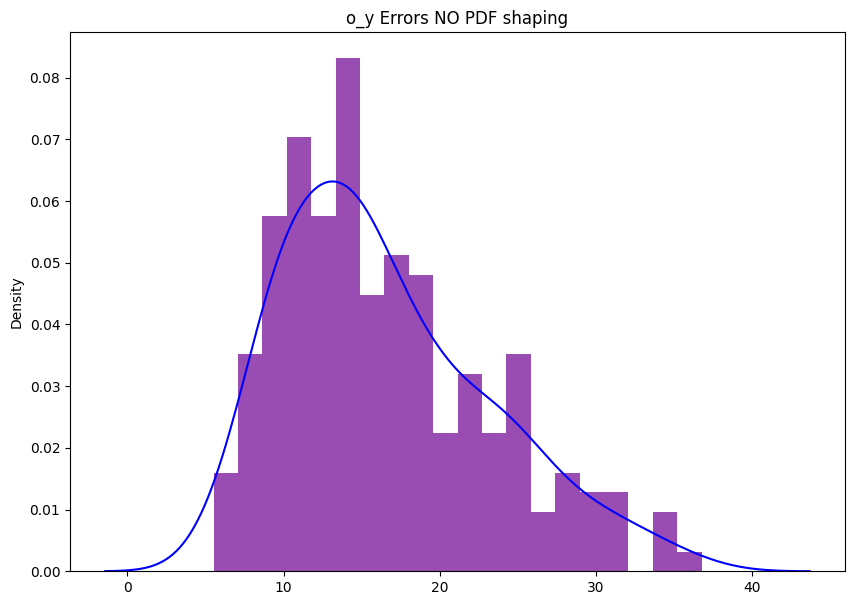

In [28]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )


## Results for g(x) = F1(x) + F2(x) with PDF shaping

F1 = Linear

F2 = Nonlinear

In [29]:

def fit_y_scaled_PDF(num_epochs, num_epochs_pdf, model, loss_fn, opt, modelSigma, opt_sigma):
    
    PDFshapingOBJ.list_metric = []
    
    PDFshapingOBJ.initializeSigmaVector()
   
    
    for epoch in range(num_epochs):
        for xb, yb in PDFshapingOBJ.train_dl:
            
            pred_descaled, pred_scaled = model(xb)
            loss = loss_fn(pred_scaled, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch % 200 == 0:
            print(epoch, " loss= ", loss)
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        r2_avg = torch.mean(torch.tensor(
                r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(r2_avg.detach().numpy())
        
        
    ## opt = torch.optim.Adam(   model.parameters(), lr=learning_rate_pdfcontrol   )    
        
    for epoch in range(num_epochs_pdf):
        
        pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
        
        ## pred_sigma_vector = modelSigma(  PDFshapingOBJ.x_range_impulse_func  )
        ## PDFshapingOBJ.sigma_func_vector_vals = pred_sigma_vector
        
        error     = pred_scaled.float() - PDFshapingOBJ.y_train_tr_scaled.float()        ## 524  X 6
        ## PDFshapingOBJ.check_error_range( error.max() )
        basisFunc = PDFshapingOBJ.train_multiple_kernels_per_output( error )         ## 4000 x 6
        
        diff = ( basisFunc.float() - PDFshapingOBJ.impulse_func_vector_vals.unsqueeze(1).float() )  ## 4000 x 6

        ## diff = diff * PDFshapingOBJ.sigma_func_vector_vals.unsqueeze(1)   ## sigma weightinng const
        ## diff = diff * pred_sigma_vector.unsqueeze(1)                         ## 4000 x 1 NN sigma weightinng
        ## diff = diff * pred_sigma_vector.reshape((4000,6))                 ## 4000 x 6 NN sigma weightinng
        
        
        loss = torch.mean(   (   diff  )**2    )  
        loss.backward()
        
        opt.step()
        opt.zero_grad()
        
        opt_sigma.step()
        opt_sigma.zero_grad()
        
  
        
        if epoch % 400 == 0:
            print(error.shape)
            print(basisFunc.shape)
            PDFshapingOBJ.print_errors_kdes(  error, basisFunc )
            print(PDFshapingOBJ.impulse_func_vector_vals.shape)
            print(epoch, " loss= ", loss)
      

        r2_avg = torch.mean(torch.tensor(
                 r2_score( pred_scaled.detach().numpy(),  PDFshapingOBJ.y_train_tr_scaled.numpy()  )
        ))
        PDFshapingOBJ.list_metric.append(  r2_avg.detach().numpy()  )
        
        
            
    PDFshapingOBJ.func_plot_performance()
            
    pred_descaled, pred_scaled = model(PDFshapingOBJ.X_train_tr)
    print('Training loss:', loss_fn(  pred_scaled,       PDFshapingOBJ.y_train_tr_scaled          ))
    print('Training R**2:', r2_score( pred_scaled.detach().numpy(), PDFshapingOBJ.y_train_tr_scaled.numpy() ))
    

In [30]:
PDFshapingOBJ.the_string           = "With_PDF_shaping"
PDFshapingOBJ.furnace_model_name   = "shaft"

torch.Size([800, 1])
torch.Size([10000, 1])


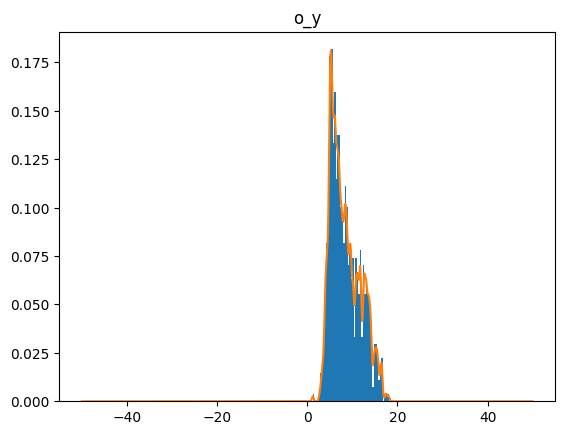

torch.Size([10000])
0  loss=  tensor(0.0292, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


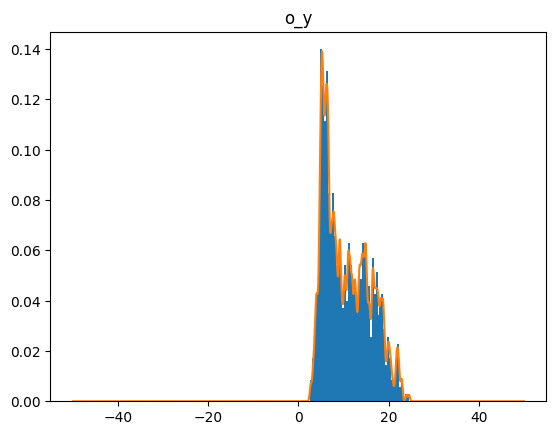

torch.Size([10000])
400  loss=  tensor(0.0289, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


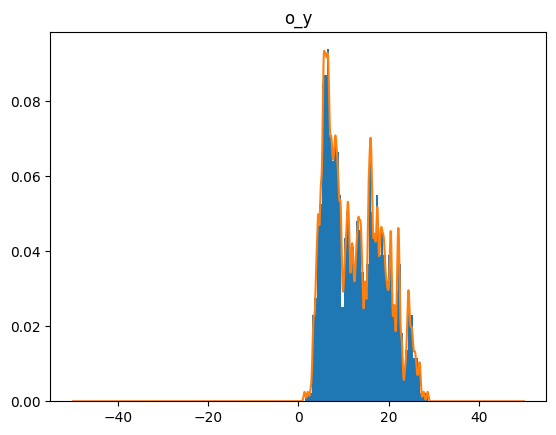

torch.Size([10000])
800  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


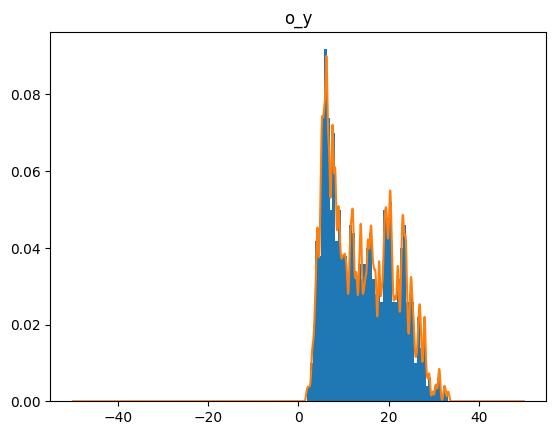

torch.Size([10000])
1200  loss=  tensor(0.0287, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


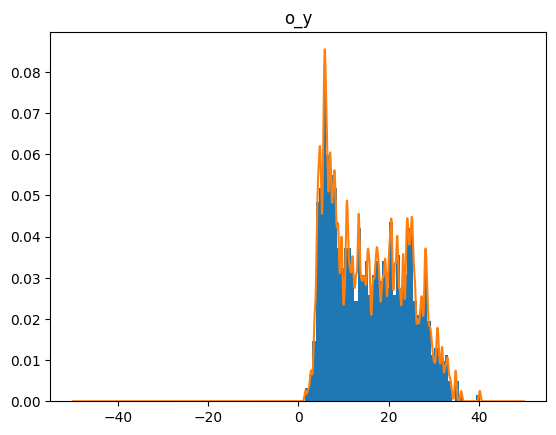

torch.Size([10000])
1600  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


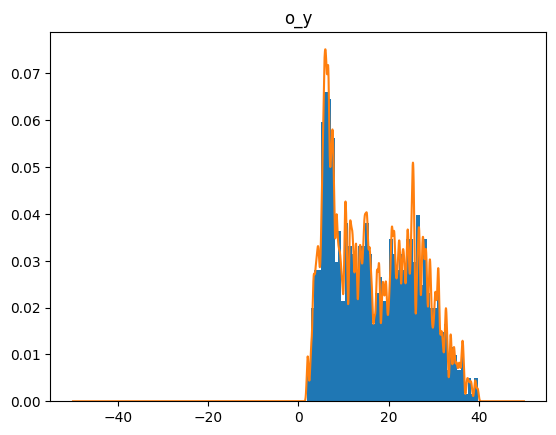

torch.Size([10000])
2000  loss=  tensor(0.0286, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


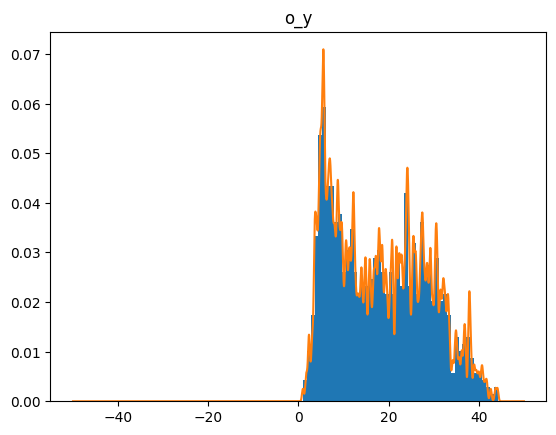

torch.Size([10000])
2400  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


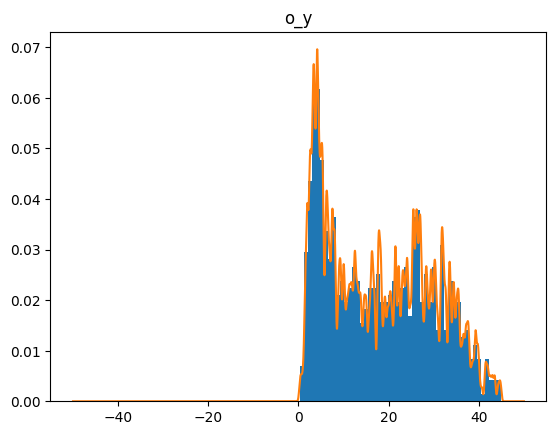

torch.Size([10000])
2800  loss=  tensor(0.0285, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


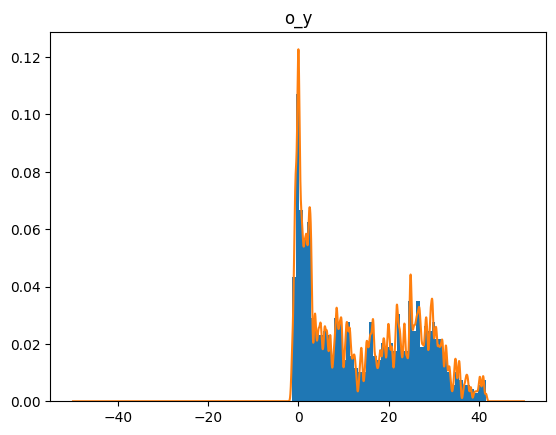

torch.Size([10000])
3200  loss=  tensor(0.0262, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


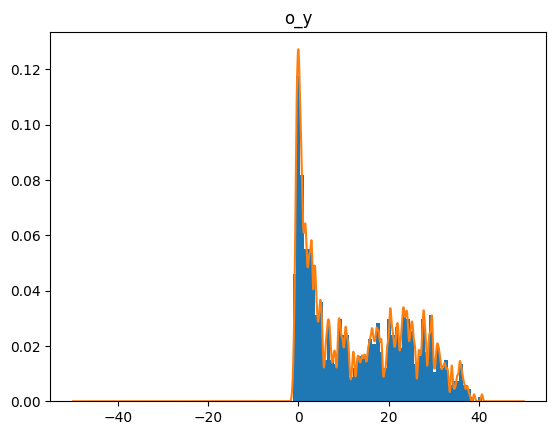

torch.Size([10000])
3600  loss=  tensor(0.0261, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


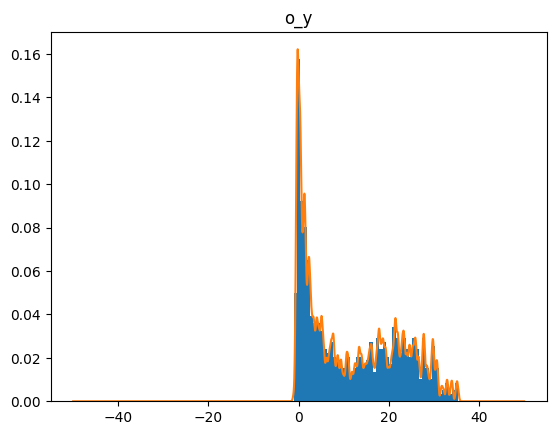

torch.Size([10000])
4000  loss=  tensor(0.0257, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


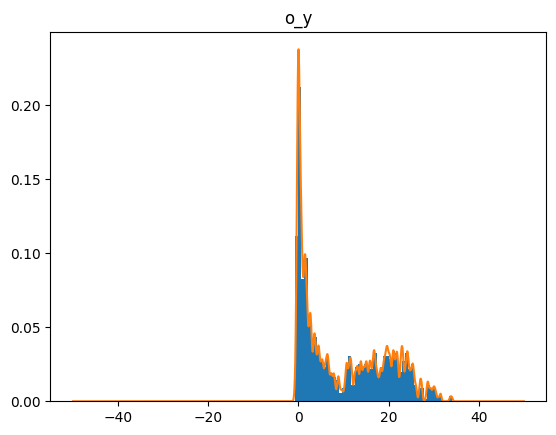

torch.Size([10000])
4400  loss=  tensor(0.0243, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


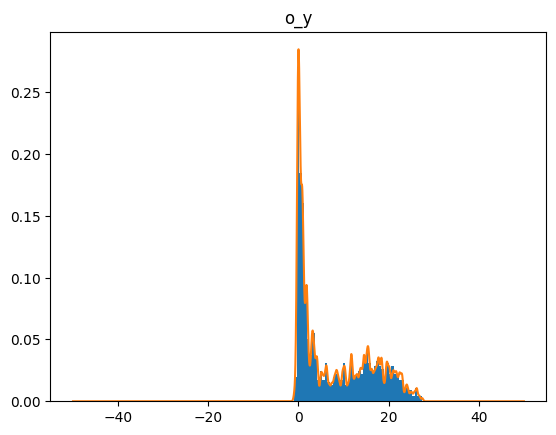

torch.Size([10000])
4800  loss=  tensor(0.0236, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


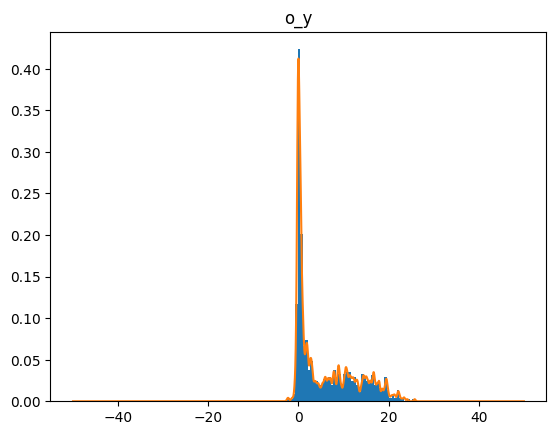

torch.Size([10000])
5200  loss=  tensor(0.0217, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


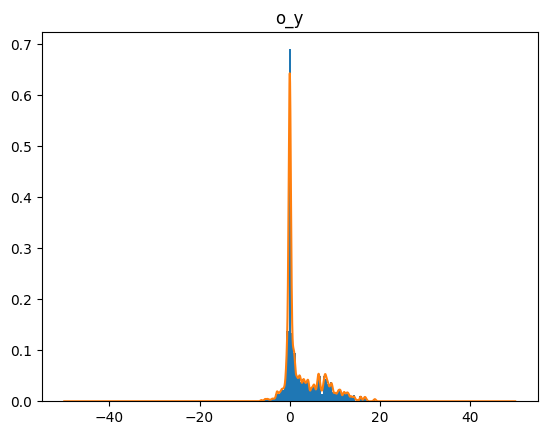

torch.Size([10000])
5600  loss=  tensor(0.0185, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


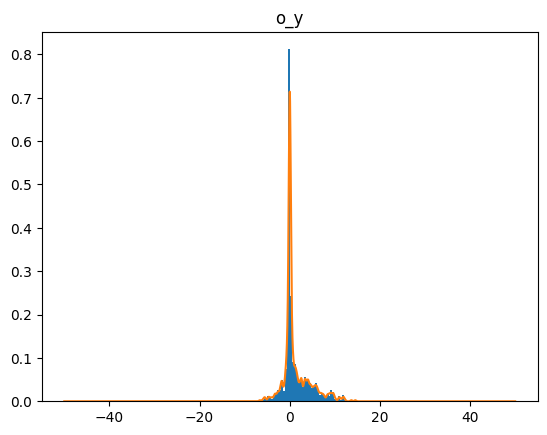

torch.Size([10000])
6000  loss=  tensor(0.0176, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


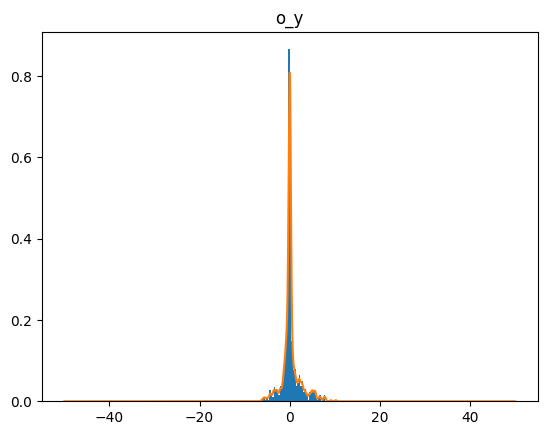

torch.Size([10000])
6400  loss=  tensor(0.0166, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


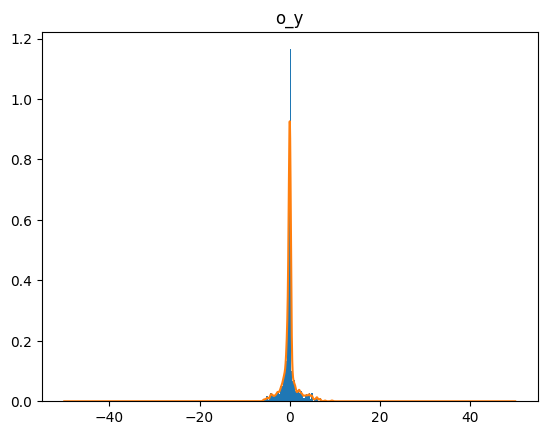

torch.Size([10000])
6800  loss=  tensor(0.0153, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


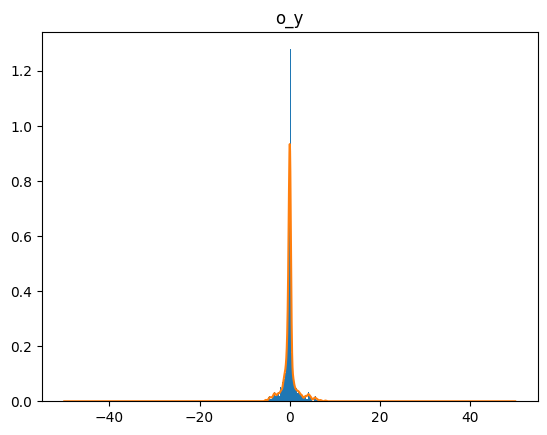

torch.Size([10000])
7200  loss=  tensor(0.0153, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


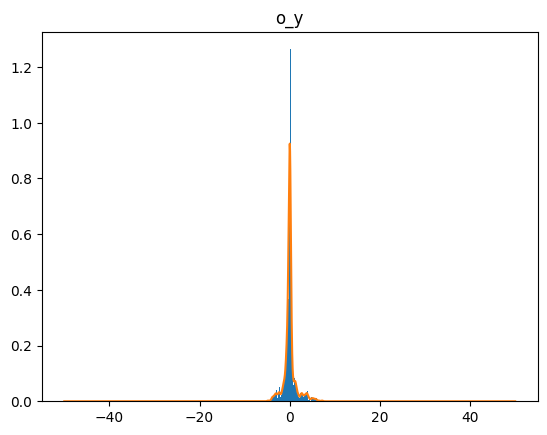

torch.Size([10000])
7600  loss=  tensor(0.0155, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


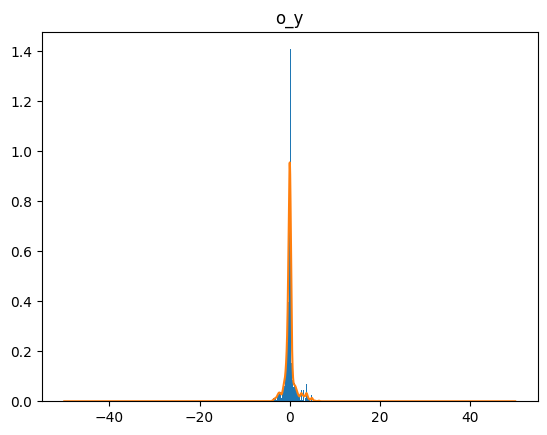

torch.Size([10000])
8000  loss=  tensor(0.0153, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


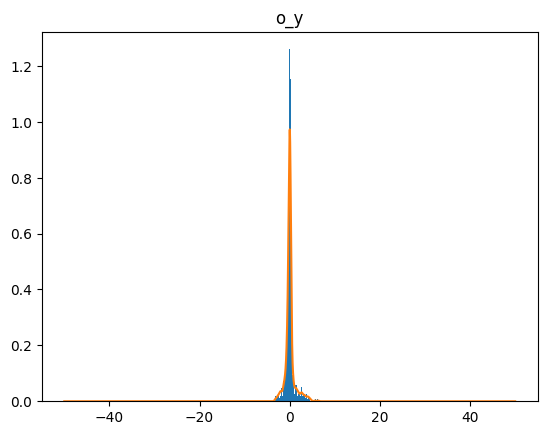

torch.Size([10000])
8400  loss=  tensor(0.0151, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


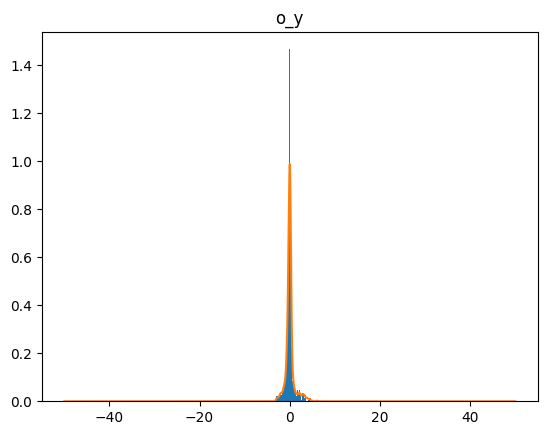

torch.Size([10000])
8800  loss=  tensor(0.0150, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


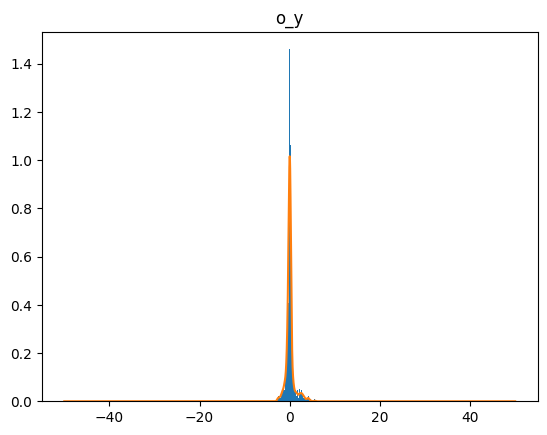

torch.Size([10000])
9200  loss=  tensor(0.0147, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


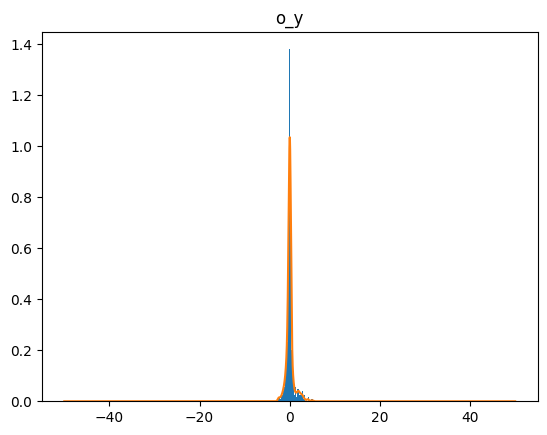

torch.Size([10000])
9600  loss=  tensor(0.0145, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


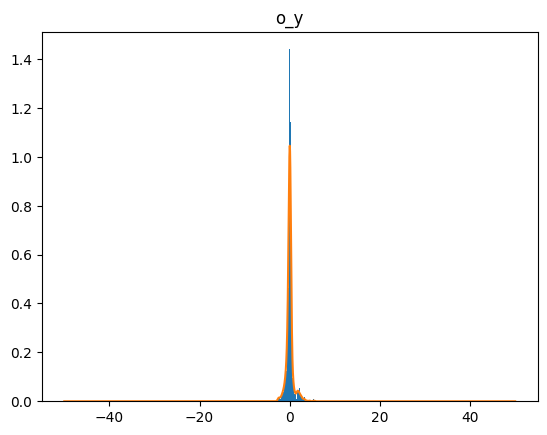

torch.Size([10000])
10000  loss=  tensor(0.0145, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


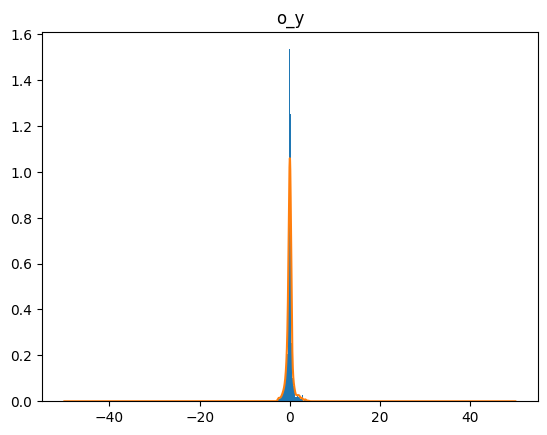

torch.Size([10000])
10400  loss=  tensor(0.0144, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


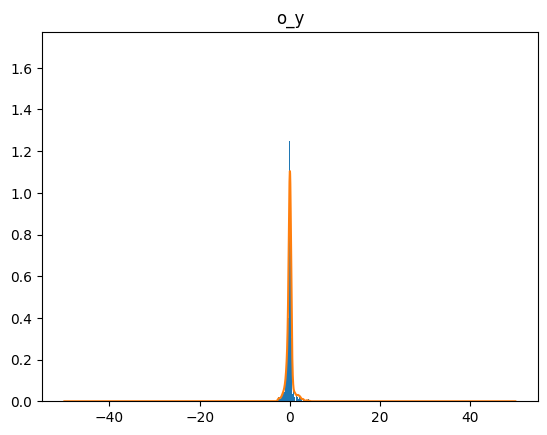

torch.Size([10000])
10800  loss=  tensor(0.0139, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


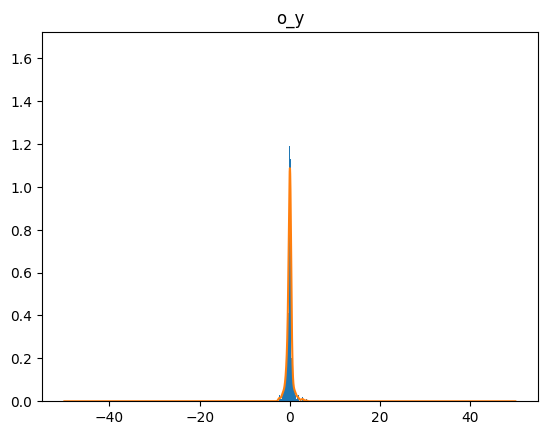

torch.Size([10000])
11200  loss=  tensor(0.0142, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


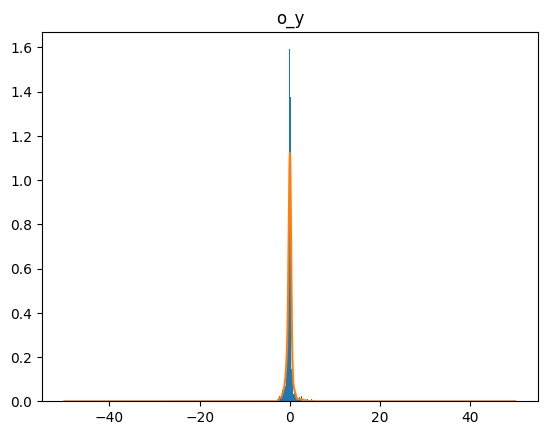

torch.Size([10000])
11600  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


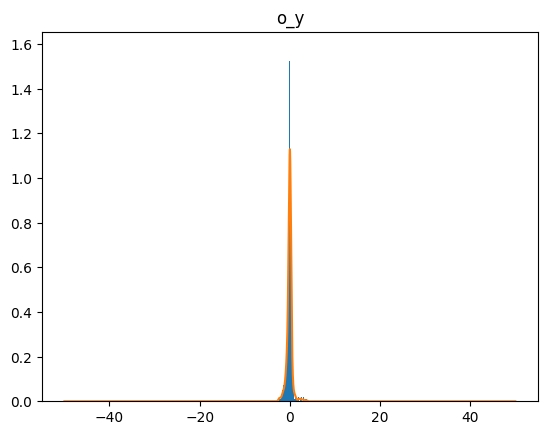

torch.Size([10000])
12000  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


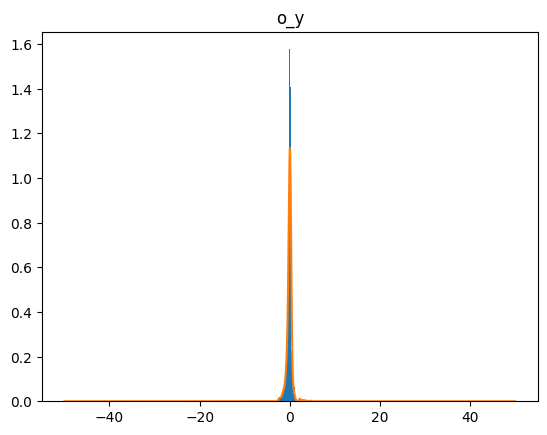

torch.Size([10000])
12400  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


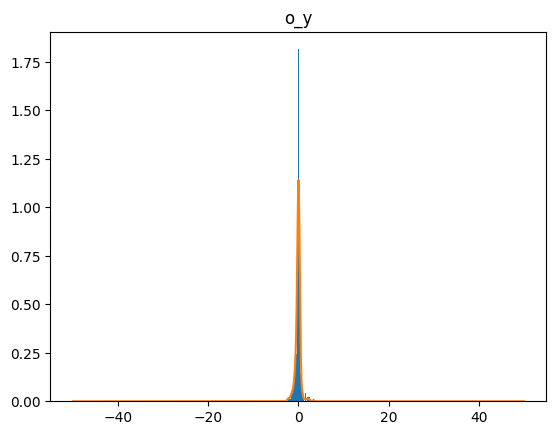

torch.Size([10000])
12800  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


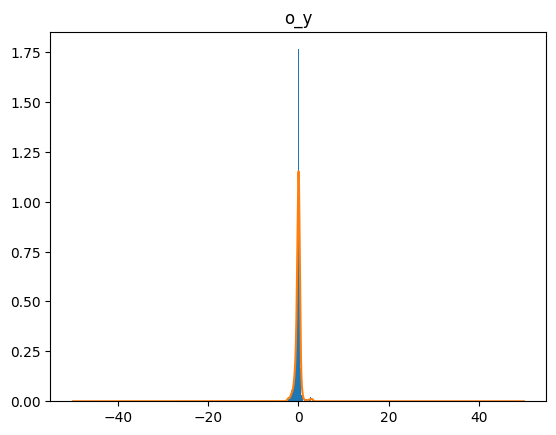

torch.Size([10000])
13200  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


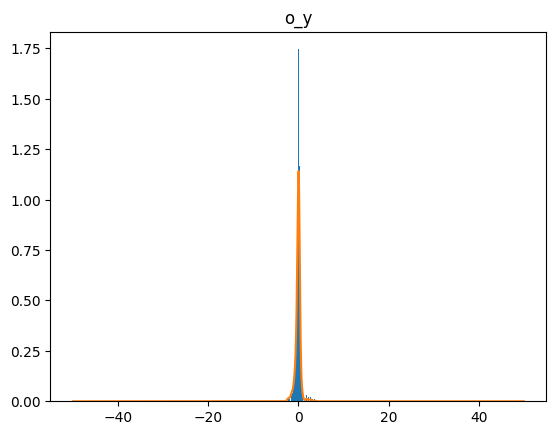

torch.Size([10000])
13600  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


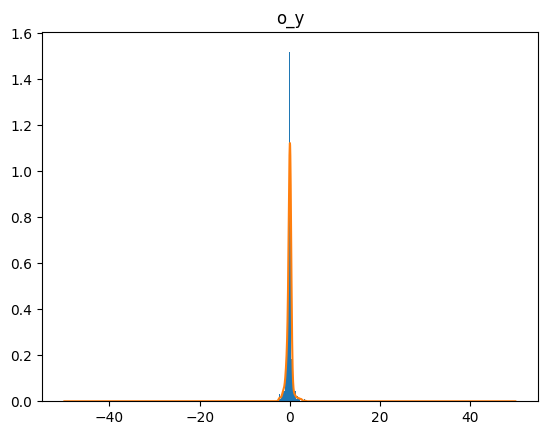

torch.Size([10000])
14000  loss=  tensor(0.0139, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


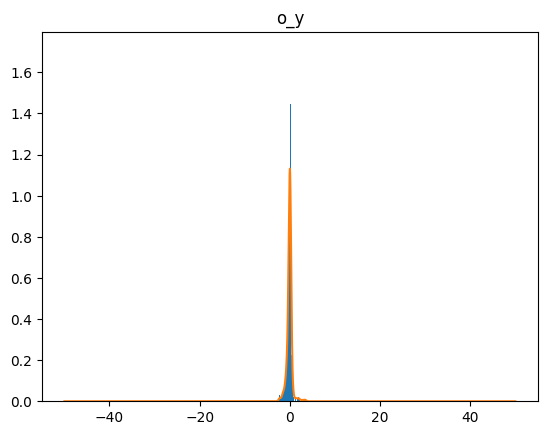

torch.Size([10000])
14400  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


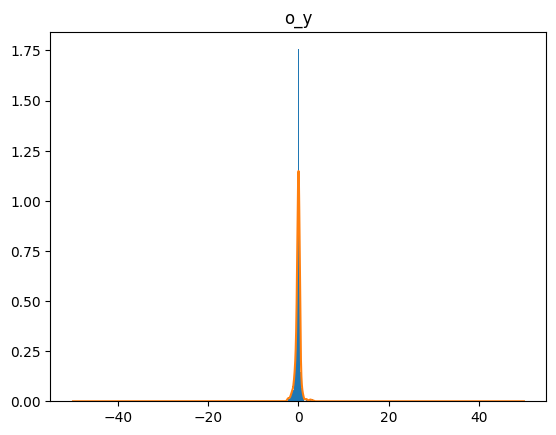

torch.Size([10000])
14800  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


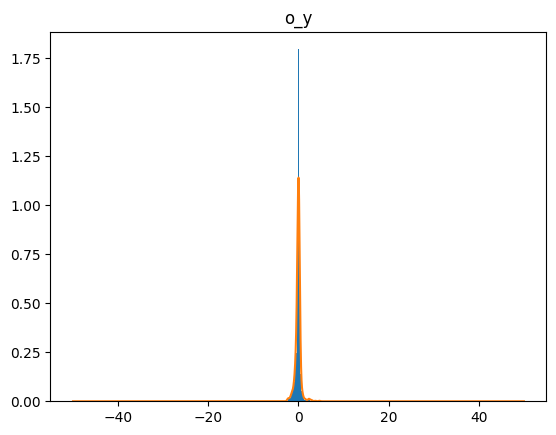

torch.Size([10000])
15200  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


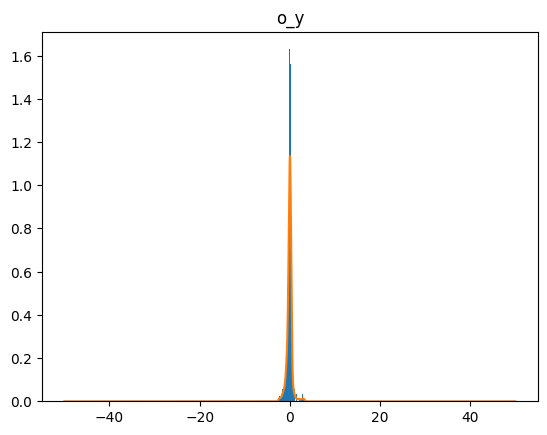

torch.Size([10000])
15600  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


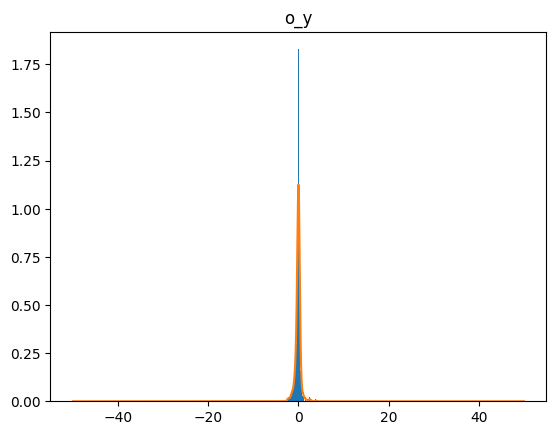

torch.Size([10000])
16000  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


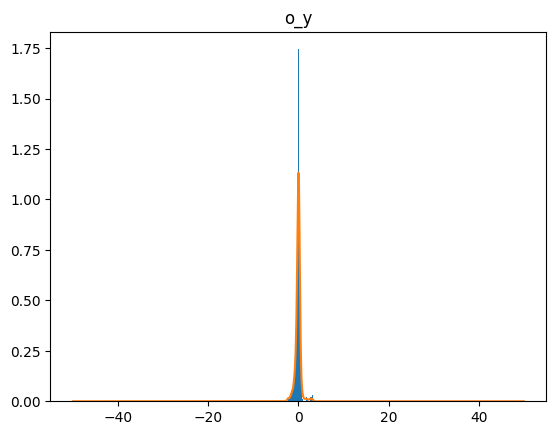

torch.Size([10000])
16400  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


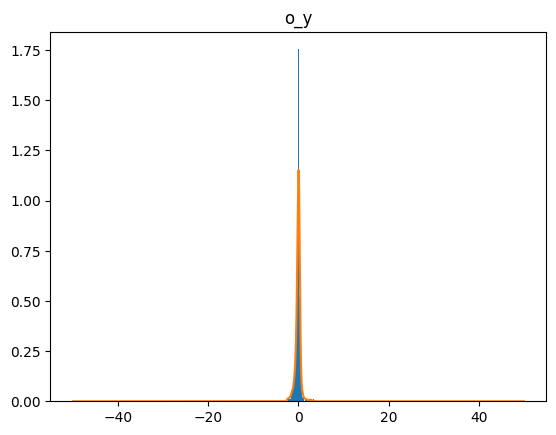

torch.Size([10000])
16800  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


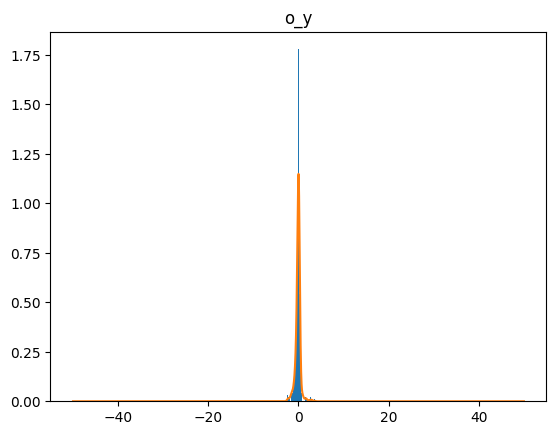

torch.Size([10000])
17200  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


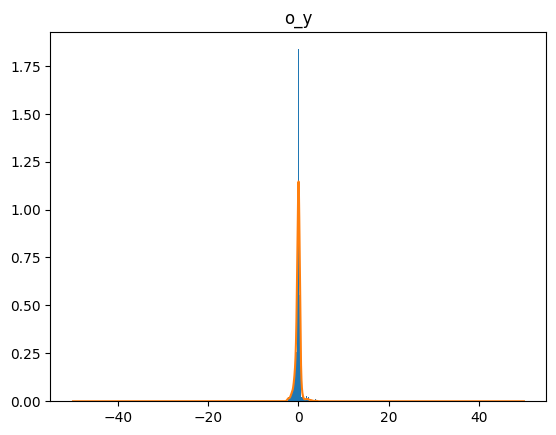

torch.Size([10000])
17600  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


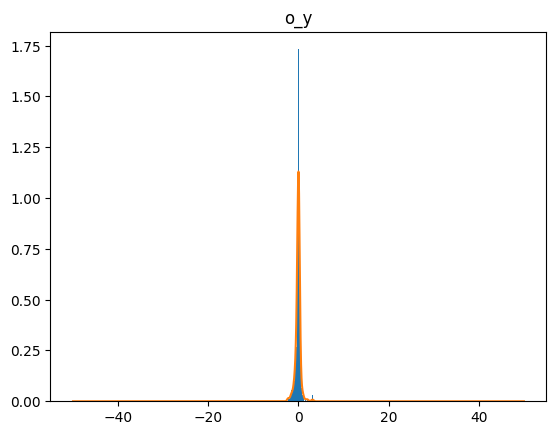

torch.Size([10000])
18000  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


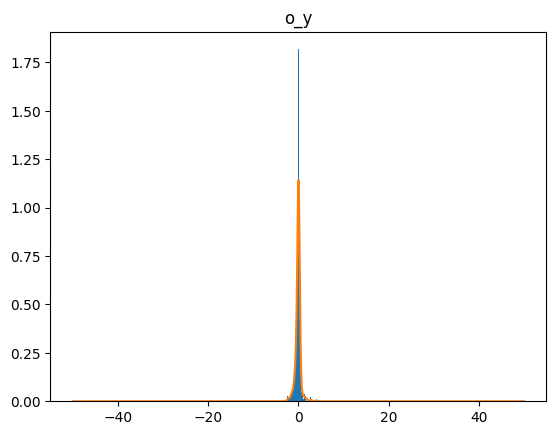

torch.Size([10000])
18400  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


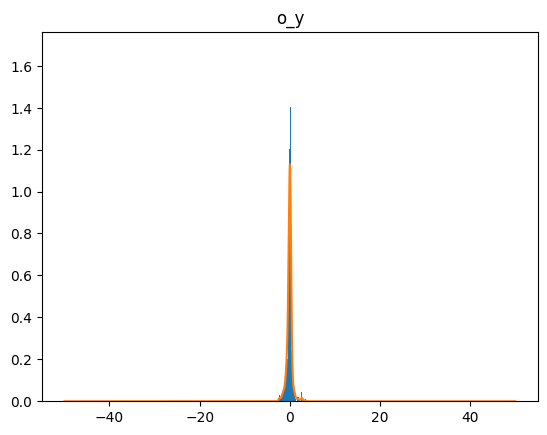

torch.Size([10000])
18800  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


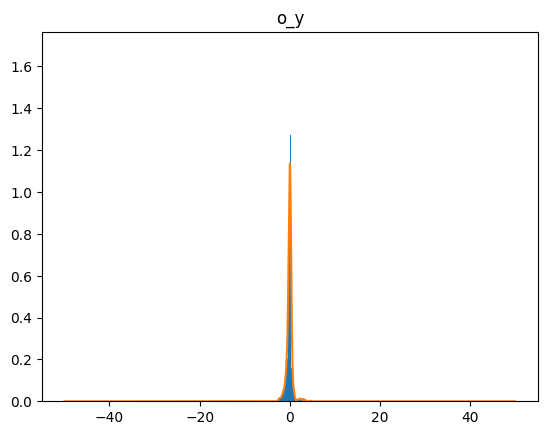

torch.Size([10000])
19200  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


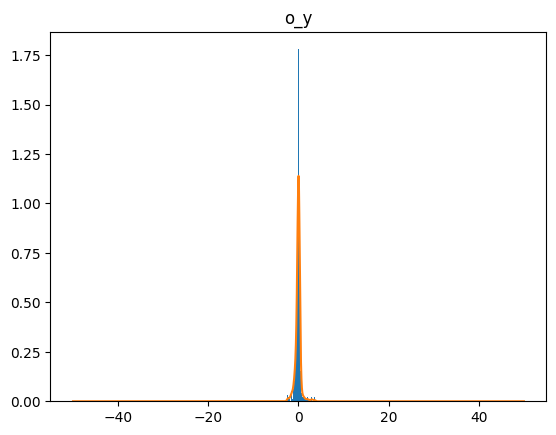

torch.Size([10000])
19600  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


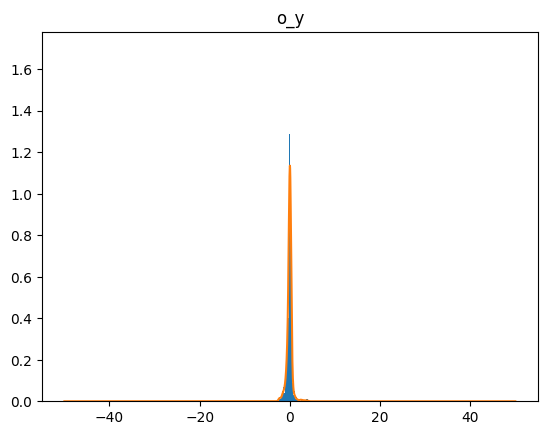

torch.Size([10000])
20000  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


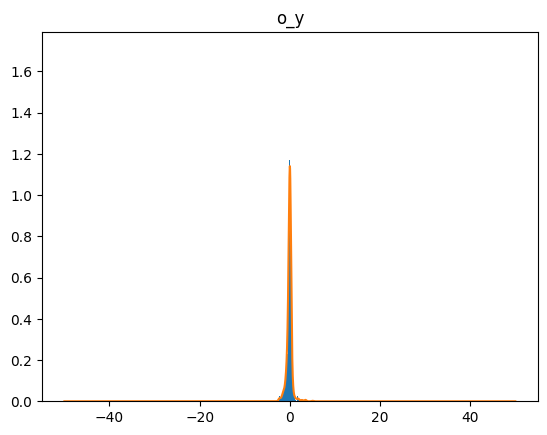

torch.Size([10000])
20400  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


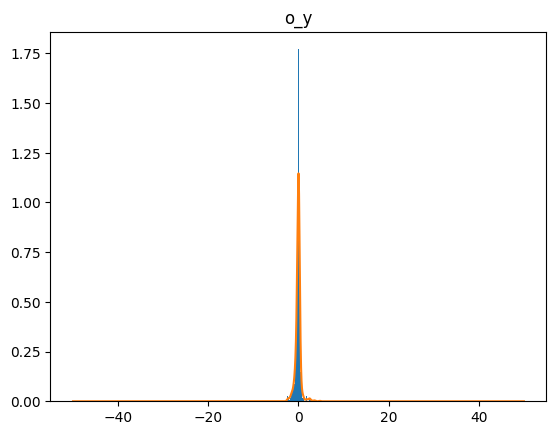

torch.Size([10000])
20800  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


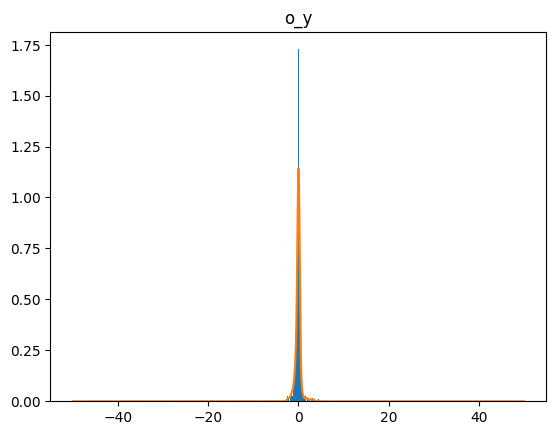

torch.Size([10000])
21200  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


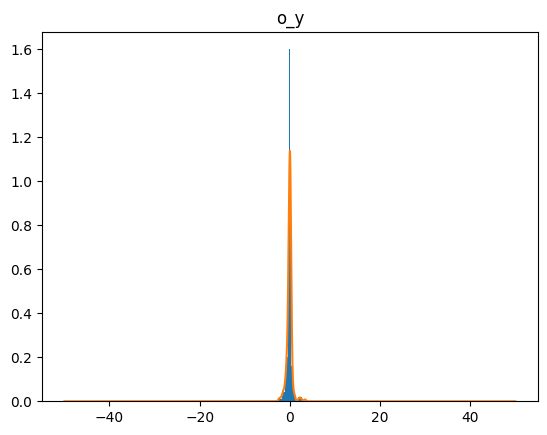

torch.Size([10000])
21600  loss=  tensor(0.0137, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


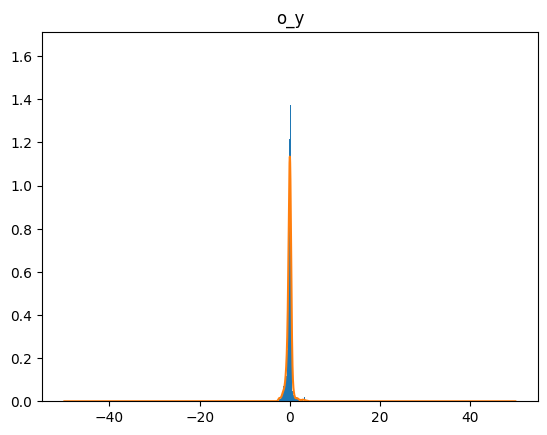

torch.Size([10000])
22000  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


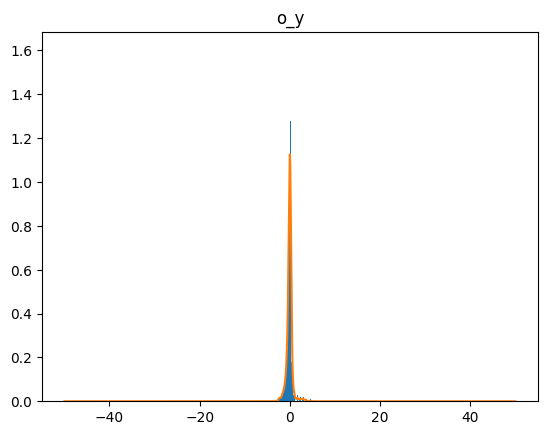

torch.Size([10000])
22400  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


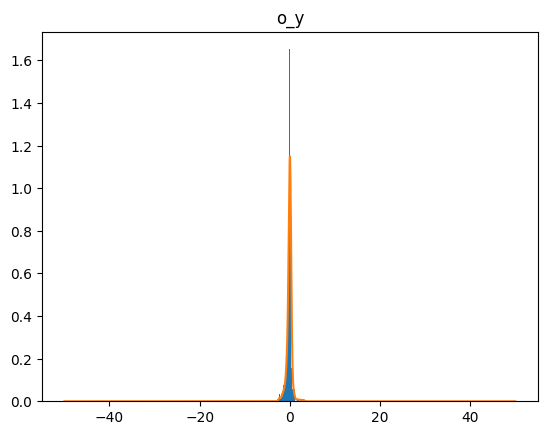

torch.Size([10000])
22800  loss=  tensor(0.0136, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


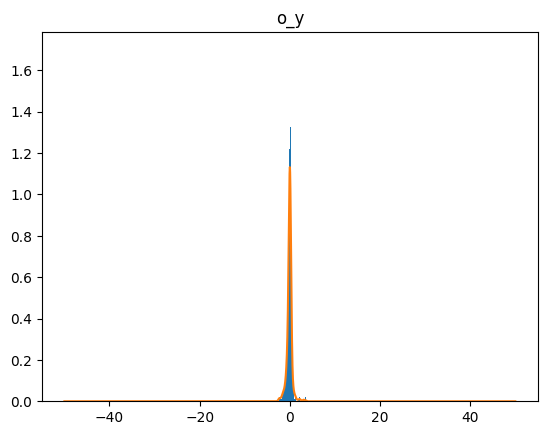

torch.Size([10000])
23200  loss=  tensor(0.0138, grad_fn=<MeanBackward0>)
torch.Size([800, 1])
torch.Size([10000, 1])


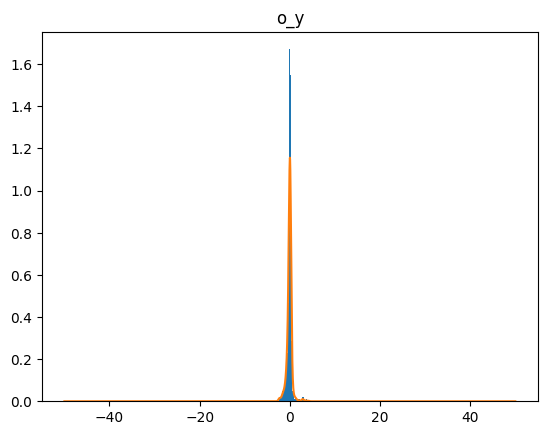

torch.Size([10000])
23600  loss=  tensor(0.0135, grad_fn=<MeanBackward0>)


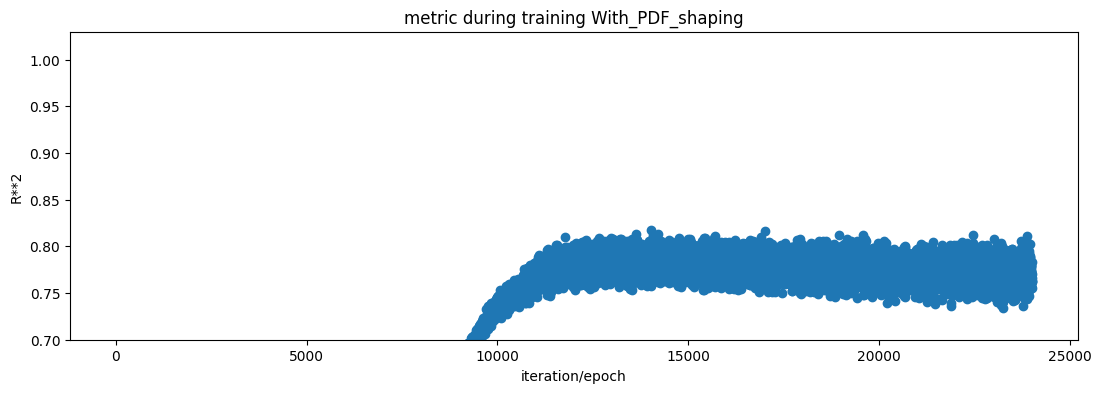

Training loss: tensor(0.3946, grad_fn=<MseLossBackward0>)
Training R**2: 0.7652920266386529
Test loss - scaled: tensor(0.4739, grad_fn=<MseLossBackward0>)
Test loss - descaled: tensor(1.7802, grad_fn=<MseLossBackward0>)
Testing R**2 - scaled: 0.7355757832812951
Testing R**2 - descaled: 0.735575760087134
*****
*****
Testing R**2 - Output: 0 o_y 0.735575760087134


In [31]:


PDFshapingOBJ.N_EPOCHS     = 0                 ## debug, remove                   
PDFshapingOBJ.N_EPOCHS_PDF = 24000              ## debug, remove


modelSigma = SigmaNN()
    

model = F1plusF2_SIO(
          PDFshapingOBJ.x_means, 
          PDFshapingOBJ.x_deviations, 
          PDFshapingOBJ.y_means, 
          PDFshapingOBJ.y_deviations
)



opt       = torch.optim.Adam(   model.parameters(), lr=PDFshapingOBJ.learning_rate   )
opt_sigma = torch.optim.Adam(   modelSigma.parameters(), lr=PDFshapingOBJ.learning_rate   )

loss_fn     = F.mse_loss


fit_y_scaled_PDF(PDFshapingOBJ.N_EPOCHS, PDFshapingOBJ.N_EPOCHS_PDF, model, loss_fn, opt, modelSigma, opt_sigma)

pred_descaled, pred_scaled = model(PDFshapingOBJ.X_test_tr)
print('Test loss - scaled:',   loss_fn(     pred_scaled,       PDFshapingOBJ.y_test_tr_scaled          ))
print('Test loss - descaled:', loss_fn(     pred_descaled,     PDFshapingOBJ.y_test_tr                 ))
print('Testing R**2 - scaled:',   r2_score( pred_scaled.detach().numpy(),PDFshapingOBJ.y_test_tr_scaled.numpy() ))
print('Testing R**2 - descaled:', r2_score( pred_descaled.detach().numpy(), PDFshapingOBJ.y_test_tr.numpy()   ))


PDFshapingOBJ.print_individual_Rsquare(pred_descaled, PDFshapingOBJ.y_test_tr)


## Now predict on test data

In [32]:

list_preds = []
list_reals = []

for i in range(len(PDFshapingOBJ.X_test_tr)):
    print("**************************************************")
    print("preds, real")
    preds_descaled, preds_scaled = model(PDFshapingOBJ.X_test_tr[i])

    np_pred = preds_descaled[0].detach().numpy()              ## [0]
    np_real = PDFshapingOBJ.y_test_tr[i].detach().numpy()

    for j in range(len(np_pred)):
        print((np_pred[j], np_real[j]))
        list_preds.append(np_pred[j])
        list_reals.append(np_real[j])

**************************************************
preds, real
(9.998684, 10.052)
**************************************************
preds, real
(10.837838, 10.844)
**************************************************
preds, real
(9.314199, 8.5311)
**************************************************
preds, real
(11.931808, 11.16)
**************************************************
preds, real
(13.984701, 12.573)
**************************************************
preds, real
(11.252929, 11.647)
**************************************************
preds, real
(10.426346, 10.231)
**************************************************
preds, real
(8.517005, 9.0179)
**************************************************
preds, real
(8.5051155, 8.6863)
**************************************************
preds, real
(7.44734, 7.9747)
**************************************************
preds, real
(10.094369, 9.977)
**************************************************
preds, real
(9.94123, 9.6171)
*************

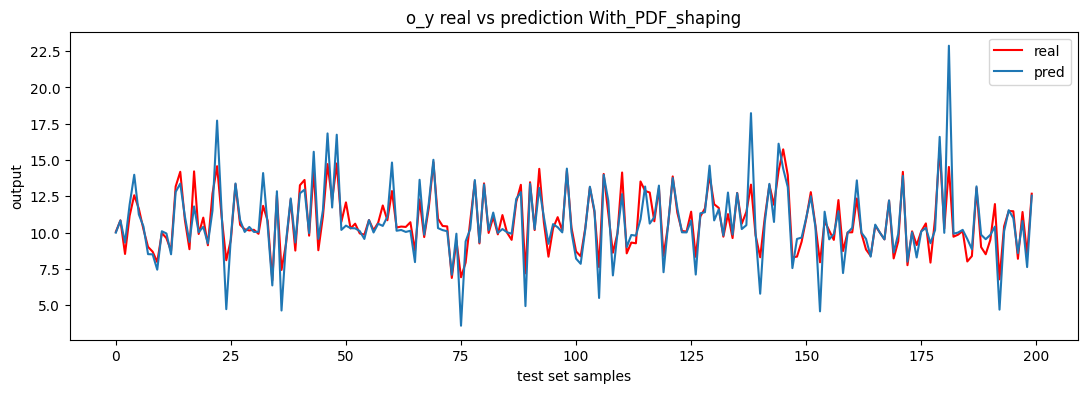

/Users/user/Desktop/DOE_CIVS/experiments/2023april/PDFshapingUtils.py:347: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error, bins=n_bins, color="blue")


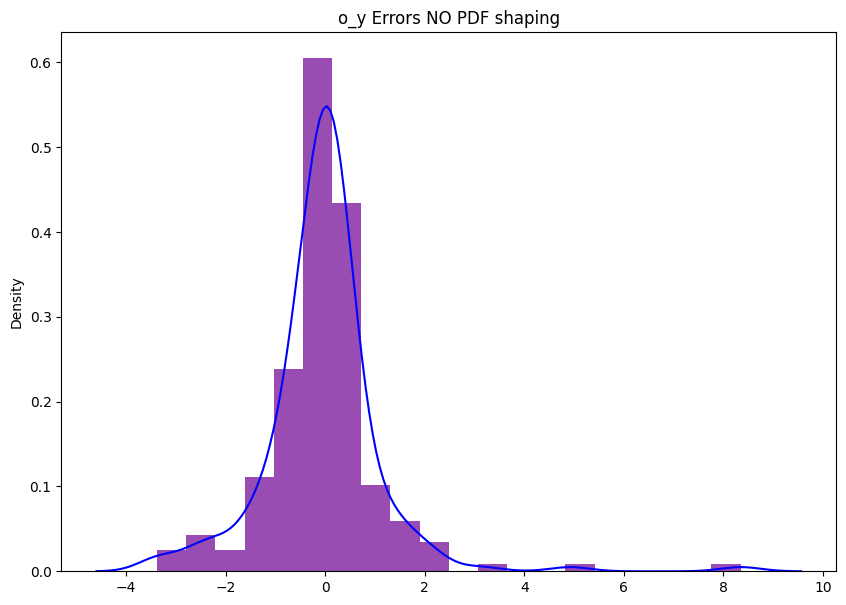

In [33]:

PDFshapingOBJ.plot_preds_vs_reals( list_preds, list_reals )


## Export ONNX model

In [ ]:

'''

model.eval()

dummy_input = torch.randn(1, 6)


input_names = ["input1"]
output_names = ["output1", "output2"]

torch.onnx.export(
  model, 
  dummy_input, 
  "ONNXmodels/s536ShaftPDFshapingRC.onnx", 
  verbose=False, 
  input_names  = input_names,
  output_names = output_names
)

'''
